In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

In [ ]:
!pip install bertopic==0.17.0
!pip install transformers==4.52.4
!pip install sentence-transformers==4.1.0
!pip install wordcloud==1.9.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.auto import tqdm


SEED = 42
tqdm.pandas()

In [2]:
dfs = []
data_path = "data/fullDataset.csv"

df = pd.read_csv(data_path)
df.head()

,text,sentiment
0,I posted this 100 years ago!,Very Positive
1,Nope,Very Negative
2,lmfao I can't believe this works,Very Negative
3,I had to beat an old lady with a stick to get ...,Very Negative
4,I had to beat an old lady with a stick to get ...,Very Negative


# Statistics

In [20]:
from typing import List

from scipy import stats
from wordcloud import WordCloud


def posts_length_statistics(posts: List[str]):
    posts_len = [len(post) for post in posts]

    median = np.median(posts_len)
    mean = np.mean(posts_len)
    std = np.std(posts_len)
    max_pdf_value = stats.norm.pdf(mean, median, std) # peak of normal curve

    plt.figure(figsize=(12, 7))
    plt.hist(posts_len, bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label='Real distribution')

    # plot normal distribution curve
    x = np.linspace(min(posts_len), max(posts_len), 1000)
    pdf = stats.norm.pdf(x, mean, std)
    plt.plot(x, pdf, 'r', linewidth=2, label='Normal distribution')

    # highlight Gaussian curve peak
    plt.scatter(mean, max_pdf_value, color='red', zorder=5, s=80,
                label=f'Gaussian Peak: {max_pdf_value:.2f}')

    # add vertical lines for statistics
    plt.axvline(float(mean), color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Mean: {mean:.1f}')
    plt.axvline(float(median), color='purple', linestyle='-.', linewidth=1.5, alpha=0.7, label=f'Median: {median:.1f}')

    # add standard deviation boundaries
    plt.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'+1σ: {mean + std:.1f}')
    plt.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'-1σ: {mean - std:.1f}')

    plt.xlabel('Sentence lengths')
    plt.ylabel('Density')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True, alpha=0.3)
    plt.show()

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
posts_length_statistics(df.text)

# Topic-Extraction

In [ ]:
import json

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from cuml.manifold import UMAP

with open ("general_topics.json") as f:
  general_topics = json.load(f)

# Maximize keywords diversity with respect to the document, i.e. # it selects
# more unique keywords per post
mmr = MaximalMarginalRelevance(diversity=0.3)
keybert = KeyBERTInspired()
representation_model = [keybert, mmr]
umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=SEED)
# update min_cluster_size to increase the number of topics (it is not the maximum number of topics)
# hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# remove stopwords AFTER topic extraction, ignore infrequent words (add min_df)
# and consider only topic made up of >= 1 words
vectorizer = CountVectorizer(stop_words="english", ngram_range=(1, 2))
# embedding_model = SentenceTransformer("all-mpnet-base-v2")
# embeddings = embedding_model.encode(df.text, show_progress=True)

topic_model = BERTopic(top_n_words=30,
                       embedding_model="thenlper/gte-small",
                       min_topic_size=15,
                       zeroshot_topic_list=list(general_topics.keys()),
                       zeroshot_min_similarity=0.7,
                       representation_model=mmr,
                       umap_model=umap,
                       vectorizer_model=vectorizer,
                       verbose=True)

topics, probs = topic_model.fit_transform(df.text) # embeddings=embeddings)
topics

In [10]:
topic_model.get_topic_info()

In [ ]:
topic_model.topic_labels_

In [13]:
general_topics_lower = {
    topic: set(k.lower() for k in keywords)
    for topic, keywords in general_topics.items()
}

topic_df = topic_model.get_topic_info()
mapped_topics = {}

# Map clustered topics to general topics based on the keyword matches
for _, row in topic_df.iterrows():
    topic_id = row["Topic"]
    topic_name = row["Name"]

    # Skip outliers and general topics
    if topic_id == -1 or not topic_name[0].isdigit():
        continue

    # Extract topic keywords
    topic_keywords = []
    for keyword in row["Representation"]:
        words = keyword.replace("_", " ").split(" ")
        topic_keywords.extend(words)

    # Match keywords to general topics
    match_counts = {}
    for general_topic, general_keywords in general_topics_lower.items():
        curr_matches = sum(1 for kw in topic_keywords if kw in general_keywords)
        if curr_matches > 0:
            match_counts[general_topic] = curr_matches

    # Assign to the best matching general topic
    best_match = max(match_counts, key=match_counts.get) if match_counts else "Outliers"
    mapped_topics[topic_id] = best_match
    
# Map general topic names to unique IDs
general_topics_ids = {}
max_id = 0

for _, row in topic_df.iterrows():
    topic_id = row["Topic"]
    topic_name = row["Name"]

    if topic_id == -1 or topic_name[0].isdigit():
        continue

    general_topics_ids[topic_name] = topic_id
    max_id = max(max_id, topic_id)

# Assign new IDs to unmapped general topics
for clustered_topic, general_topic in mapped_topics.items():
    if "-1" not in general_topic and general_topic not in general_topics_ids:
        if general_topic == "Outliers":
            general_topics_ids[general_topic] = -1
        else:
            general_topics_ids[general_topic] = max_id
            max_id += 1
            
# Map clustered topics to final general topic IDs
for clustered_topic_id, general_topic in mapped_topics.items():
    mapped_topics[clustered_topic_id] = general_topics_ids[general_topic]

updated_topics_labels = [k for k in sorted(general_topics_ids.keys(), key=general_topics_ids.get)]
updated_topics = [
    mapped_topics.get(topic_id, topic_id)
    for topic_id in topics
]

print(len(updated_topics_labels))
len(updated_topics_labels) == len(set(updated_topics))

40


True

In [14]:
topic_model.update_topics(df.text, topics=updated_topics)
topic_model.set_topic_labels(updated_topics_labels)
topic_model.get_topic_info()

2025-06-03 22:43:45,108 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,105232,-1_the_of_to_and,Outliers,"[the, of, to, and, he, is, in, that, you, for]",NaN
1,0,224046,0_social_bsky_you_to,Social Media,"[social, bsky, you, to, it, the, and, of, my, me]",[@paradisefound67.bsky.social \n\nbsky.app/pro...
2,1,138541,1_the_to_of_and,Politics,"[the, to, of, and, is, in, trump, that, for, he]",[the difference between trump voters in conser...
3,2,82030,2_game_the_games_to,Gaming,"[game, the, games, to, it, and, play, of, in, ...",[If you gate-keep something just because you k...
4,3,68719,3_thanksgiving_happy_turkey_food,General Activities,"[thanksgiving, happy, turkey, food, and, the, ...","[happy thanksgiving ^_^, Analysis and reportin..."
5,4,53523,4_music_song_the_album,Music,"[music, song, the, album, spotify, of, com, to...","[Happy Thanksgiving! 🫶🏾❤️, Happy thanksgiving ..."
6,5,48296,5_to_the_in_and,Traveling,"[to, the, in, and, it, you, my, on, of, for]",[Just saw him at the Macy's Thanksgiving Day P...
7,6,45161,6_thank_you_so_love,Fashion & Style,"[thank, you, so, love, cute, look, and, my, th...","[open.spotify.com/track/5FoffJ..., WA X RW X....."
8,7,54261,7_it_the_to_com,Gadgets & Devices,"[it, the, to, com, for, on, is, that, and, of]",[Happy Thanksgiving to everyone who celebrates...
9,8,41244,8_to_the_for_and,Programming,"[to, the, for, and, it, in, you, this, is, on]","[Why thank you 💙💜, Thank you very much ❤️❤️❤️,..."


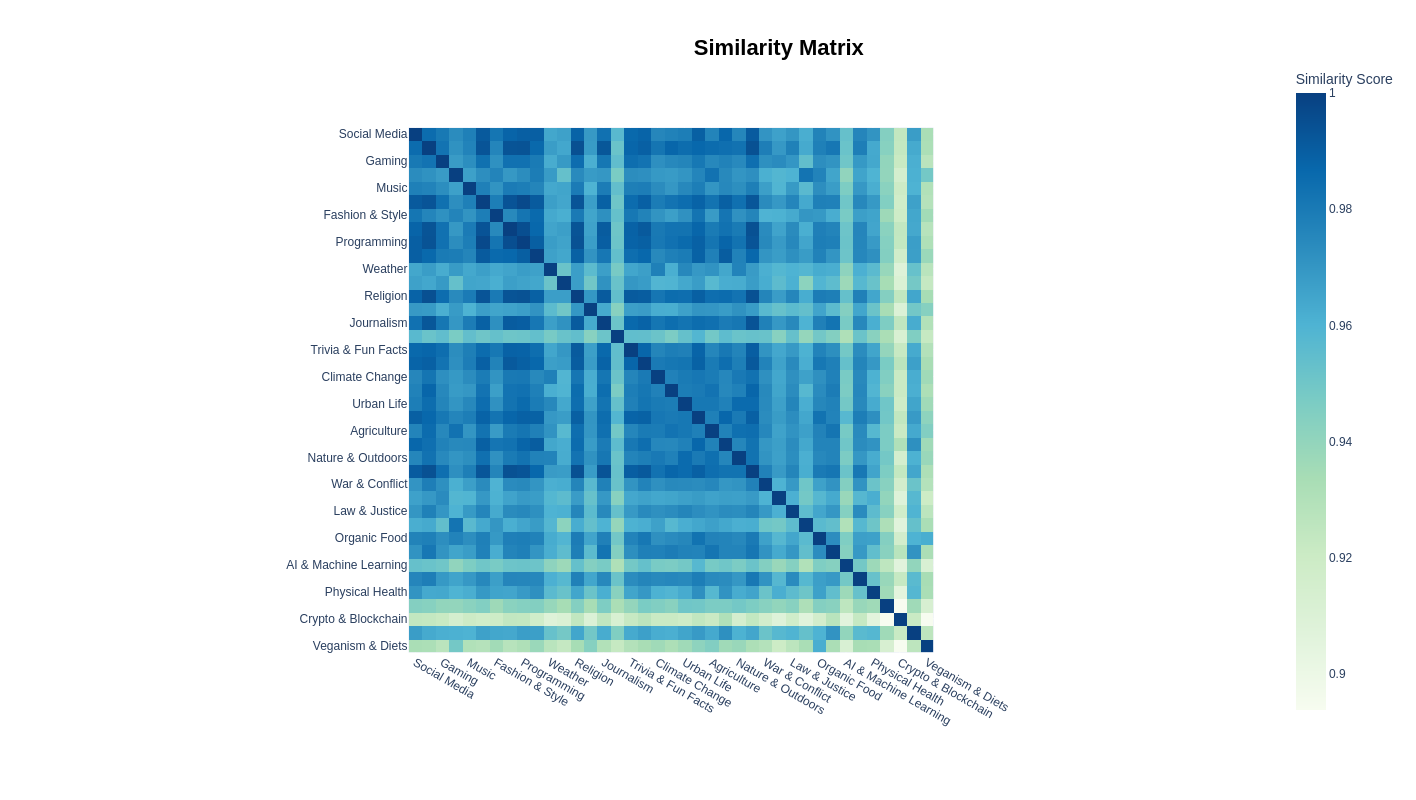

In [15]:
topic_model.visualize_heatmap(custom_labels=True)

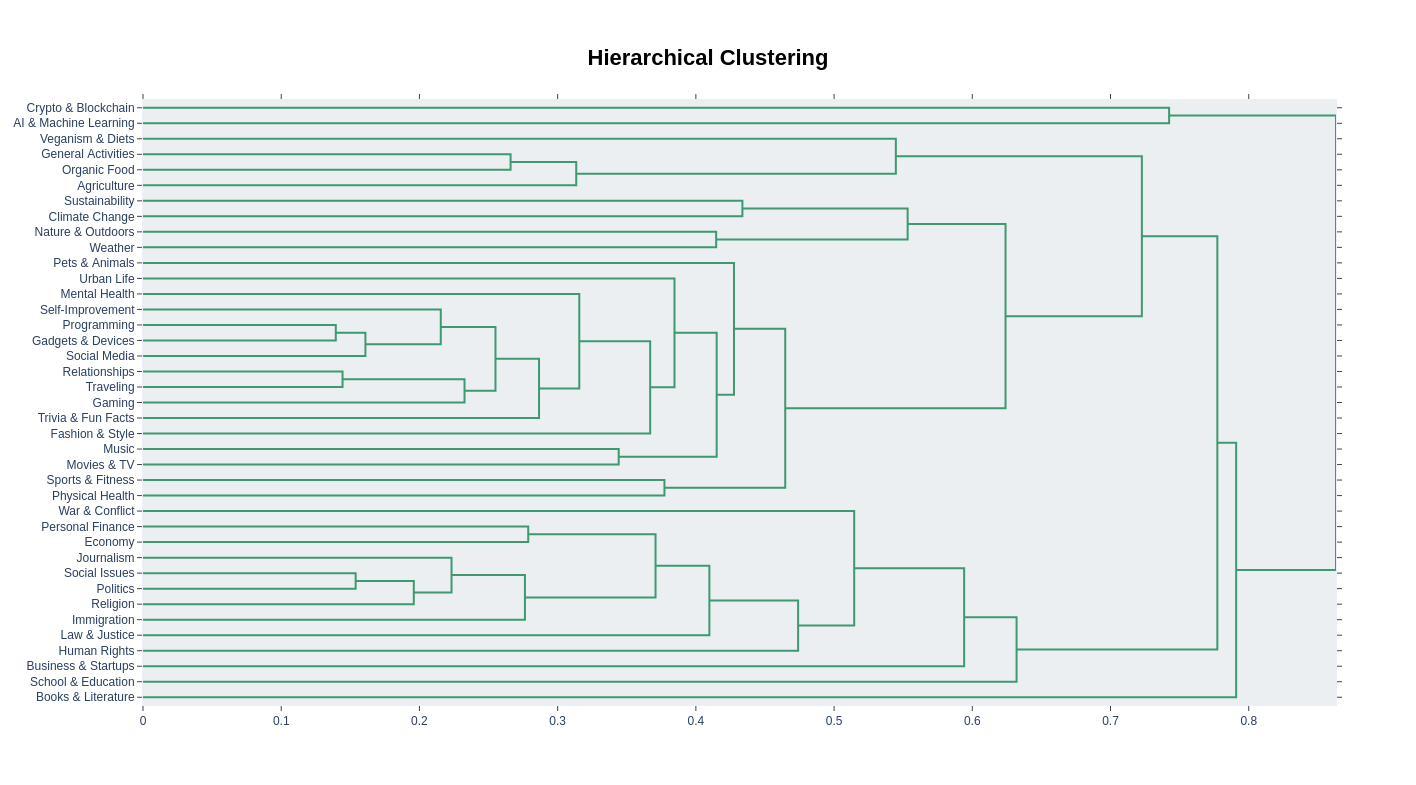

In [16]:
topic_model.visualize_hierarchy(custom_labels=True)

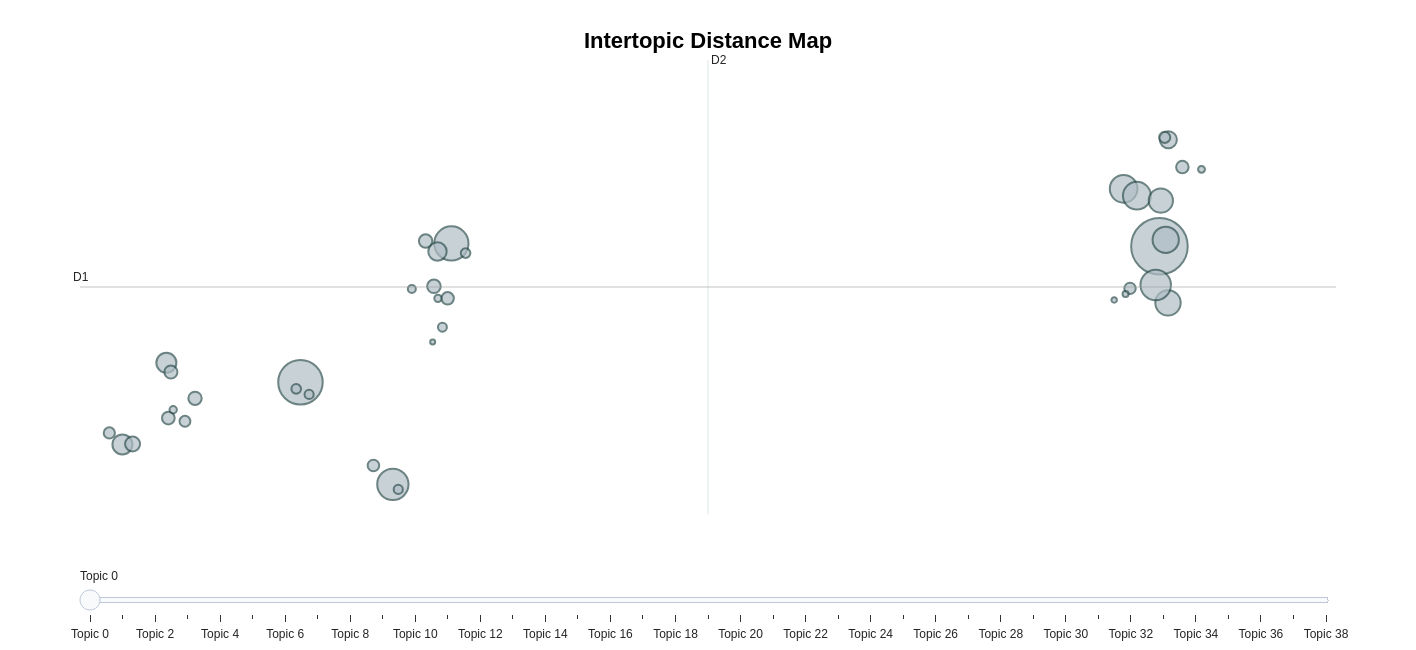

In [17]:
topic_model.visualize_topics(custom_labels=True)

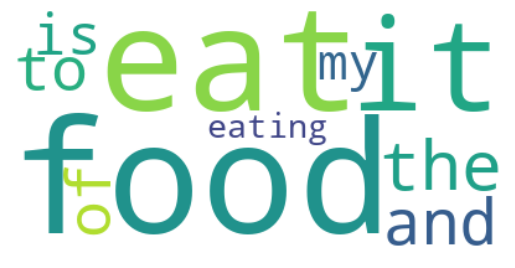

In [22]:
create_wordcloud(topic_model, 30)

In [23]:
inv_general_topics_ids = {v: k for k, v in general_topics_ids.items()}
inv_general_topics_ids

{0: 'Social Media',
 1: 'Politics',
 2: 'Gaming',
 3: 'General Activities',
 -1: 'Outliers',
 4: 'Music',
 5: 'Traveling',
 6: 'Fashion & Style',
 7: 'Gadgets & Devices',
 8: 'Programming',
 9: 'Relationships',
 10: 'Weather',
 11: 'Movies & TV',
 12: 'Religion',
 13: 'Pets & Animals',
 14: 'Journalism',
 15: 'Books & Literature',
 16: 'Trivia & Fun Facts',
 17: 'Self-Improvement',
 18: 'Climate Change',
 19: 'Immigration',
 20: 'Urban Life',
 21: 'Mental Health',
 22: 'Agriculture',
 23: 'Personal Finance',
 24: 'Nature & Outdoors',
 25: 'Social Issues',
 26: 'War & Conflict',
 27: 'Sports & Fitness',
 28: 'Law & Justice',
 29: 'Sustainability',
 30: 'Organic Food',
 31: 'Economy',
 32: 'AI & Machine Learning',
 33: 'Human Rights',
 34: 'Physical Health',
 35: 'School & Education',
 36: 'Crypto & Blockchain',
 37: 'Business & Startups',
 38: 'Veganism & Diets'}

In [28]:
# add topic label to dataset
df["Topic"] = ""

for idx, row in tqdm(df.iterrows(), desc="Adding topic labels..."):
    df.at[idx, "Topic"] = inv_general_topics_ids[updated_topics[idx]]

df.head()

Adding topic labels...: 0it [00:00, ?it/s]

,text,sentiment,Topic
0,I posted this 100 years ago!,Very Positive,Social Media
1,Nope,Very Negative,Politics
2,lmfao I can't believe this works,Very Negative,Gadgets & Devices
3,I had to beat an old lady with a stick to get ...,Very Negative,General Activities
4,I had to beat an old lady with a stick to get ...,Very Negative,General Activities


In [29]:
df.to_csv("data/fullDataset2.csv", index=False)